# Drake practice - "Direct" Joint Angle Teleop
First, we provide a reference to the first example notebook of chapter 1. Then, in the bottom cell, you will find a similar function with slightly different functionality, and code missing that you are required to fill in. Take a look below for further instructions!

## Review: 2D End-effector Teleop (from Chapter 1)

In the chapter 1 [example](https://manipulation.csail.mit.edu/intro.html#teleop2d), we assembled a diagram with the manipulation station, a meshcat visualizer, some systems that provide a minimal teleop interface, along with some systems to convert the teleop output from end-effector commands into joint commands.

In this problem, your goal is to build an even simpler diagram, which instead directly controls the joint angles of the robot.


## Setup
Imports from drake and starting the Meshcat viewer.

In [1]:
import numpy as np
from pydrake.all import DiagramBuilder, LeafSystem, Simulator, StartMeshcat

from manipulation import running_as_notebook
# from manipulation.exercises.grader import Grader
# from manipulation.exercises.robot.test_direct_joint_control import (
#     TestDirectJointControl,
# )
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()
meshcat.Set2dRenderMode(xmin=-0.25, xmax=1.5, ymin=-0.1, ymax=1.3)

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [4]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://manipulation/planar_iiwa14_no_collision.urdf
    default_joint_positions:
        iiwa_joint_2: [0.1]
        iiwa_joint_4: [-1.2]
        iiwa_joint_6: [1.6]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
model_drivers:
    iiwa: !IiwaDriver
        control_mode: position_only
        desired_kp_gains: [500, 500, 200]
"""
scenario = LoadScenario(data=scenario_data)

## Directly control the robot joints
You'll now get a chance to replace the teleop functionality in the 2D example above with a direct "joint angle setter".

Compete the `teleop_2d_direct` function below accepting a desired angle of each joint from the user.
- Reference `teleop_2d` in the chapter 1 example.
- You can leave out all the components that were used in `teleop_2d` which are no longer needed.

### The goals of this exercise are twofold:
- Understand the way core subsystems in Drake are wired together well enough to know what parts of the `teleop_2d` function must be removed.
- Use the information in the examples from the textbook, other exercises, and Drake documentation, to correctly implement the same high-level joint-space control behavior, but using a different Drake function.


In [ ]:
class CommandInputSystem(LeafSystem):
    def __init__(self, interactive, q_cmd):
        LeafSystem.__init__(self)

        self._interactive = interactive
        self._q_cmd = q_cmd

        # Declare input and output ports.
        self._q_current_input = self.DeclareVectorInputPort(name="q_current", size=3)
        self.DeclareVectorOutputPort(name="q_cmd", size=3, calc=self.CalcOutput)

    def CalcOutput(self, context, output):
        # Read the input port.
        q_current = self._q_current_input.Eval(context)

        if self._interactive and running_as_notebook and self._q_cmd is None:
            q_cmd = q_current.copy()
            q_cmd[0] = float(
                input(
                    f"Please enter value for first movable joint (current value: {q_current[0]:.3f})"
                )
            )
            q_cmd[1] = float(
                input(
                    f"Please enter value for second movable joint (current value: {q_current[1]:.3f})"
                )
            )
            q_cmd[2] = input(
                f"Please enter value for third movable joint (current value: {q_current[2]:.3f})"
            )
            self._q_cmd = q_cmd
        else:
            q_cmd = self._q_cmd

        # if q_cmd is None:
        #     q_cmd = np.zeros(3)

        # Write to the output port.
        output.SetFromVector(q_cmd)

    def reset(self):
        self._q_cmd = None


def teleop_2d_direct(interactive=False, q_cmd=None):
    """
    Joint position control of the Kuka iiwa robot, without using teleop sliders or differential IK.

    Args:
        interactive (bool): If True, function will query the user to manually set the desired joint positions
            while running the simulator. Otherwise, function will use "q_cmd" as the target joint position.
        q_cmd (np.ndarray, list): Shape (3,). Desired positions of the three movable joints on the 2D robot.
            "q_cmd" cannot be None if "interactive" is set to False.
    """
    assert (
        not interactive and q_cmd is not None
    ) or interactive, 'Variable "q_cmd" must not be None if the function is run in non-interactive mode'

    builder = DiagramBuilder()

    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))

    command_input_system = builder.AddSystem(CommandInputSystem(interactive, q_cmd))


    #######################################################################
    # # Your code here

    # command_input_system_context = command_input_system.CreateDefaultContext()
    # print(f"Command Input System Context: {command_input_system_context}")
    builder.Connect(command_input_system.get_output_port(0), station.get_input_port(0))
    builder.Connect(station.GetOutputPort("iiwa.position_measured"), command_input_system.get_input_port(0))
    #
    command_input_system
    station.GetInputPort("iiwa.position").FixValue(context,command_input_system)
    station.GetOutputPort("iiwa.position_measured").Eval(station_context)   
    
    # (hint: what output ports does the `station` instance have available?)

    #######################################################################

    diagram = builder.Build()

    #######################################################################
    # Your code here. We wish to construct the following:
    # 1. simulator
    # 2. context: The context variable is set to the context owned by the simulator. What public member function can we use to get this context? See https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_simulator.html
    # 3. station_context: We want a context for the station that is retrieved from the context owned by the simulator. See "Subcontext access" at https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    station_context = station.CreateDefaultContext()
    print(f"Station Context: {station_context}")
    RenderDiagram(station,max_depth=1)
    #######################################################################

    if simulator is None:
        print("You must set the simulator variable above")
        return station, station_context

    simulator.set_target_realtime_rate(1.0 if interactive else 0)
    meshcat.AddButton("Stop Simulation")
    while meshcat.GetButtonClicks("Stop Simulation") < 1:
        # Command the desired positions for 2s while simulating.
        simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)

        q_current_cmd = station.GetOutputPort("iiwa.position_commanded").Eval(
            station_context
        )
        print(f"Current commanded joint angles: {q_current_cmd}")

        if not interactive or not running_as_notebook:
            break
        else:
            # Reset the input system so that it asks for user input.
            command_input_system.reset()

    meshcat.DeleteButton("Stop Simulation")

    return station, station_context

In [ ]:
class CommandInputSystem(LeafSystem):
    def __init__(self, interactive, q_cmd):
        LeafSystem.__init__(self)

        self._interactive = interactive
        self._q_cmd = q_cmd

        # Declare input and output ports.
        self._q_current_input = self.DeclareVectorInputPort(name="q_current", size=3)
        self.DeclareVectorOutputPort(name="q_cmd", size=3, calc=self.CalcOutput)

    def CalcOutput(self, context, output):
        # Read the input port.
        q_current = self._q_current_input.Eval(context)

        if self._interactive and running_as_notebook and self._q_cmd is None:
            q_cmd = q_current.copy()
            q_cmd[0] = float(
                input(
                    f"Please enter value for first movable joint (current value: {q_current[0]:.3f})"
                )
            )
            q_cmd[1] = float(
                input(
                    f"Please enter value for second movable joint (current value: {q_current[1]:.3f})"
                )
            )
            q_cmd[2] = float(
                input(
                    f"Please enter value for third movable joint (current value: {q_current[2]:.3f})"
                )
            )
            self._q_cmd = q_cmd
        else:
            q_cmd = self._q_cmd

        # Write to the output port.
        output.SetFromVector(q_cmd)

    def reset(self):
        self._q_cmd = None


def teleop_2d_direct(interactive=False, q_cmd=None):
    """
    Joint position control of the Kuka iiwa robot, without using teleop sliders or differential IK.

    Args:
        interactive (bool): If True, function will query the user to manually set the desired joint positions
            while running the simulator. Otherwise, function will use "q_cmd" as the target joint position.
        q_cmd (np.ndarray, list): Shape (3,). Desired positions of the three movable joints on the 2D robot.
            "q_cmd" cannot be None if "interactive" is set to False.
    """
    assert (
        not interactive and q_cmd is not None
    ) or interactive, 'Variable "q_cmd" must not be None if the function is run in non-interactive mode'

    builder = DiagramBuilder()

    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))

    command_input_system = builder.AddSystem(CommandInputSystem(interactive, q_cmd))

    #######################################################################
    # Connect the input and output port of `command_input_system` to the `station` ports
    builder.Connect(command_input_system.get_output_port(0), station.GetInputPort("iiwa.position"))
    builder.Connect(station.GetOutputPort("iiwa.position_measured"), command_input_system.get_input_port(0))
    #######################################################################

    diagram = builder.Build()

    #######################################################################
    # Construct the simulator and contexts
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context() # difference between getmutable_context() and CreateDefaultContext()
    station_context = diagram.GetMutableSubsystemContext(station, context)
    RenderDiagram(diagram,max_depth=1)
    #######################################################################

    if simulator is None:
        print("You must set the simulator variable above")
        return station, station_context

    simulator.set_target_realtime_rate(1.0 if interactive else 0)
    meshcat.AddButton("Stop Simulation")
    while meshcat.GetButtonClicks("Stop Simulation") < 1:
        # Command the desired positions for 2s while simulating.
        simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)

        q_current_cmd = station.GetOutputPort("iiwa.position_commanded").Eval(
            station_context
        )
        print(f"Current commanded joint angles: {q_current_cmd}")

        if not interactive or not running_as_notebook:
            break
        else:
            # Reset the input system so that it asks for user input.
            command_input_system.reset()

    meshcat.DeleteButton("Stop Simulation")

    return station, station_context

Run the cell below to use the function you wrote in an interactive mode, but note that the autograder will test the functionality of your code in non-interactive mode.

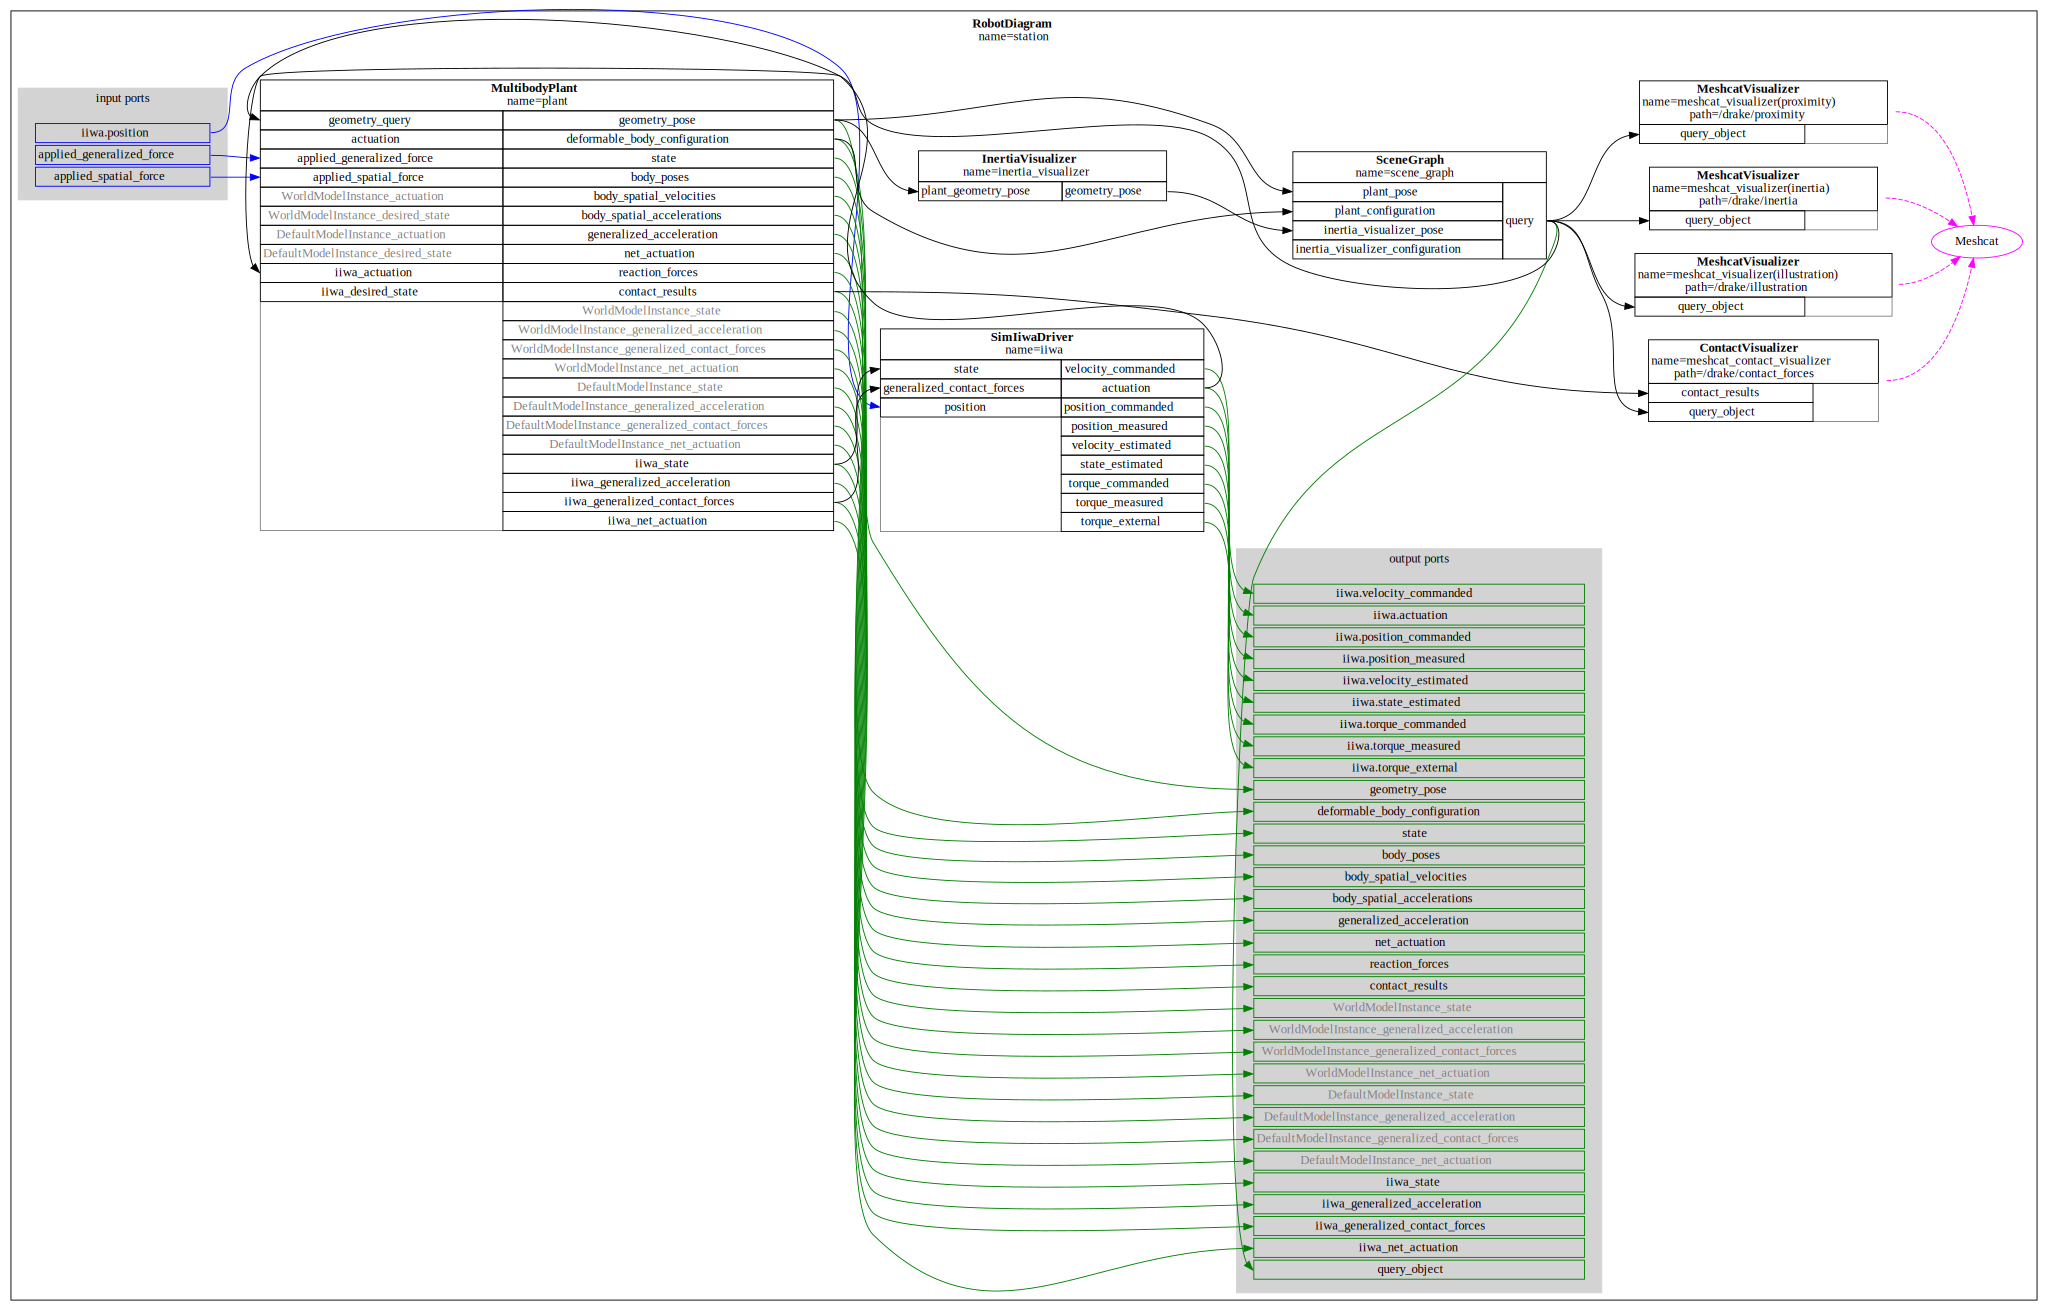

Current commanded joint angles: [0. 0. 0.]


(<pydrake.planning.RobotDiagram at 0x7ec8e921fe30>,
 <pydrake.systems.framework.Context at 0x7ec9085e75b0>)

In [ ]:
teleop_2d_direct(interactive=False, q_cmd=np.array([0.1, 0.1, 0.1]))

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza.

For submission of this assignment, you must do as follows:.
- Download and submit the notebook `direct_joint_control.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [5pts] `teleop_2d_direct` must be implemented correctly (i.e., we will check if you are properly sending position commands to the robot)

Below is our autograder where you can check your score!

In [8]:
Grader.grade_output([TestDirectJointControl], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 0/5.

Score for Test iiwa_position_measured is 0/5.
- Current commanded joint angles: [0. 0. 0.]

Test Failed: np.float64(0.37416573867739417) not less than or equal to 0.001 : wrong commanded position



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d47f800-dc57-418e-ab91-0720ef24520e' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>